# Environment

In [264]:
import google.cloud.bigquery as bigquery, pandas as pd, matplotlib.pyplot as plt, seaborn as snsn, numpy as np, \
importlib

In [257]:
import src.utils.evaluation as evaluation

In [333]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
)

# Data

In [436]:
client = bigquery.Client()

In [437]:
query = """
SELECT
  *
FROM
  stackoverflow.posts_preprocessed_selection_subset
"""

In [438]:
df = client.query(query).to_dataframe()

In [439]:
df.head()

,id,title,text_body,code_body,tags
0,28728142,newbie get expect expression error compile code,take introductory class have trouble compile c...,include cs50 include stdio int main void int h...,[c]
1,16905513,pic 18f46k22 mikroc try implement usart interrupt,18f pic work request datum uart source receive...,loopvar while uart1 data ready stay datum buff...,[c]
2,22348213,gcc attribute influence nested function,function attribute specify function declaratio...,invalid line hot nested function invisible out...,[c]
3,23095398,address truncation,try truncate start address large multiple equa...,uintptr roundedvar uintptr start 0xf,[c]
4,18675170,return value function return value,function return return value example code,include stdio int f1 void f2 void main printf ...,[c]


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55848 entries, 0 to 55847
Data columns (total 5 columns):
id           55848 non-null object
title        55848 non-null object
text_body    55848 non-null object
code_body    55848 non-null object
tags         55848 non-null object
dtypes: object(5)
memory usage: 2.1+ MB


# Naive Bayes (Single-Label Classification)

In [441]:
x = df['code_body'] + df['title']
y = df['tags'].apply(lambda row: " ".join(row))

In [442]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=30)

In [443]:
estimators = [
    ('tfidf', TfidfVectorizer(tokenizer=lambda string: string.split())),
    ('clf', MultinomialNB()),
]
parameters = {
    'tfidf__min_df': np.arange(10, 30, 10),
    'tfidf__max_df': np.arange(0.75, 0.9, 0.05),
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'clf__alpha': np.arange(0.2, 1, 0.2),
}

In [444]:
p = Pipeline(estimators)
grid = RandomizedSearchCV(p, param_distributions=parameters,
                           scoring='balanced_accuracy', n_iter=20, cv=3, n_jobs=-1)

In [445]:
score = grid.fit(x_train, y_train)

In [446]:
y_pred = grid.predict(x_test)

In [447]:
print(classification_report(y_test, y_pred))

/home/.conda-env/env_nlp_text_class/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

          .net       0.00      0.00      0.00       106
          ajax       0.00      0.00      0.00        23
       android       0.76      0.86      0.81      1154
     angularjs       0.94      0.65      0.77       152
        arrays       0.00      0.00      0.00        37
       asp.net       0.67      0.27      0.38       168
   asp.net-mvc       0.61      0.12      0.21        89
             c       0.72      0.48      0.58       273
            c#       0.48      0.68      0.56       927
           c++       0.65      0.75      0.70       673
           css       0.67      0.54      0.59       168
      database       0.00      0.00      0.00        44
        django       0.98      0.40      0.57       100
       eclipse       1.00      0.02      0.04        56
         excel       0.82      0.67      0.74       133
      facebook       0.75      0.10      0.17        61
         forms       0.00      0.00      0.00  

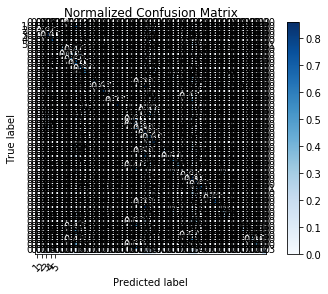

In [448]:
cm = confusion_matrix(y_test, y_pred)
evaluation.plot_confusion_matrix(cm=cm, classes=range(1, 6), normalize=True)

In [449]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y_test, y_pred))

Accuracy: 0.6128021486123545
Balanced accuracy: 0.3166376476428201
Cohen's cappa coefficient: 0.5837824994206284


# Support Vector Machine (Single-Label Classification)

In [407]:
x2 = df['code_body'] + df['title']
y2 = df['tags'].apply(lambda row: ' '.join(row))

In [408]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, stratify=y2, random_state=30)

In [412]:
estimators2 = [
    ('tfidf', TfidfVectorizer(tokenizer=lambda string: string.split())),
    ('clf', SGDClassifier(n_jobs=-1))
]
parameters2 = {
    'tfidf__min_df': np.arange(10, 30, 10),
    'tfidf__max_df': np.arange(0.75, 0.9, 0.05),
    'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'clf__alpha': (1e-2, 1e-3)
}

In [419]:
p2 = Pipeline(estimators2)
grid2 = RandomizedSearchCV(p2, param_distributions=parameters2, 
                           scoring='balanced_accuracy', n_iter=20, cv=3, n_jobs=-1)

In [420]:
score2 = grid2.fit(x2_train, y2_train)

In [421]:
y2_pred = grid.predict(x2_test)

In [422]:
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

     android       0.89      0.87      0.88      1155
          c#       0.85      0.76      0.80       927
        java       0.81      0.86      0.83      1276
  javascript       0.86      0.82      0.84       685
         php       0.82      0.87      0.85       851

    accuracy                           0.84      4894
   macro avg       0.84      0.84      0.84      4894
weighted avg       0.84      0.84      0.84      4894



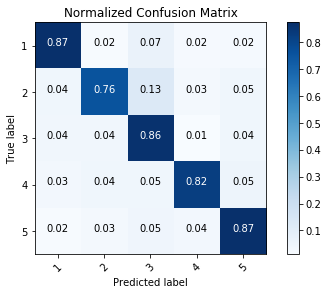

In [423]:
cm2 = confusion_matrix(y2_test, y2_pred)
evaluation.plot_confusion_matrix(cm=cm2, classes=range(1, 6), normalize=True)

In [424]:
print('Accuracy:', accuracy_score(y2_test, y2_pred))
print('Balanced accuracy:', balanced_accuracy_score(y2_test, y2_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y2_test, y2_pred))

Accuracy: 0.8414384961176952
Balanced accuracy: 0.8377815927881562
Cohen's cappa coefficient: 0.7991165079546603


# Naive Bayes (Multi-Label Classification)

In [347]:
x2 = df["code_body"] + df["title"]
y2 = df["tags"].apply(lambda row: " ".join(row))

In [348]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, stratify=y, random_state=30)

In [374]:
estimators2 = [
    ("tfidf", TfidfVectorizer(tokenizer=lambda string: string.split())),
    ("clf", OneVsRestClassifier(MultinomialNB(), n_jobs=1)),
]
parameters2 = {
    "tfidf__min_df": np.arange(10, 30, 10),
    "tfidf__max_df": np.arange(0.75, 0.9, 0.05),
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__estimator__alpha": np.arange(0.2, 1, 0.2),
}

In [377]:
p2 = Pipeline(estimators2)
grid2 = RandomizedSearchCV(
    p2, param_distributions=parameters2, n_iter=20, cv=3, n_jobs=-1
)

In [378]:
score2 = grid2.fit(x2_train, y2_train)

In [379]:
y2_pred = grid2.predict(x2_test)

In [380]:
print(classification_report(y2_test, y2_pred))

              precision    recall  f1-score   support

     android       0.89      0.89      0.89      1155
          c#       0.85      0.75      0.80       927
        java       0.81      0.87      0.84      1276
  javascript       0.87      0.82      0.85       685
         php       0.83      0.88      0.86       851

    accuracy                           0.85      4894
   macro avg       0.85      0.84      0.85      4894
weighted avg       0.85      0.85      0.85      4894



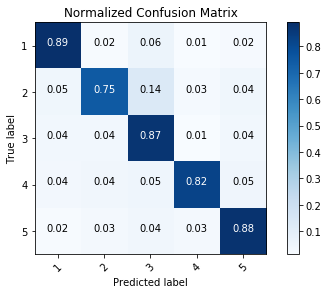

In [381]:
cm = confusion_matrix(y2_test, y2_pred)
evaluation.plot_confusion_matrix(cm=cm, classes=range(1, 6), normalize=True)

In [382]:
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print("Balanced accuracy:", balanced_accuracy_score(y2_test, y2_pred))
print("Cohen's Cappa Coefficient", cohen_kappa_score(y2_test, y2_pred))

Accuracy: 0.8475684511646915
Balanced accuracy: 0.8428282590127865
Cohen's Cappa Coefficient 0.8067754684733933


# Support Vector Machine (Multi-Label Classification)

In [24]:
x2 = df["code_body"]
y2 = MultiLabelBinarizer().fit_transform(df["tags"].tolist())

In [25]:
x2_train, x2_test, y2_train, y2_test = train_test_split(
    x2, y2, test_size=0.2, random_state=30
)

In [26]:
estimators = [
    ("tfidf", TfidfVectorizer(tokenizer=lambda string: string.split())),
    ("clf", OneVsRestClassifier(SGDClassifier(n_jobs=-1), n_jobs=-1)),
]
parameters = {
    "tfidf__min_df": np.arange(0.01, 0.05, 0.01),
    "tfidf__max_df": np.arange(0.75, 0.9, 0.05),
    "tfidf__ngram_range": [(1, 1), (2, 2), (3, 3)],
    "clf__estimator__alpha": (1e-2, 1e-3),
}

In [29]:
p2 = Pipeline(estimators)
grid2 = RandomizedSearchCV(
    p, param_distributions=parameters, n_iter=20, cv=3, scoring="roc_auc", n_jobs=-1
)

In [30]:
score2 = grid.fit(x2_train, y2_train)

In [31]:
y2_pred = grid.predict(x_test)

In [ ]:
print(classification_report(y2_test, y2_pred))
print(accuracy_score(y2_test, y2_pred))

# ToDo